In [8]:
import numpy as np
import os
from skimage.measure import block_reduce
from scipy.misc import imread
import cPickle as pkl
import scipy.signal
import numpy.fft as fft
import sys
import optparse
from libtiff import TIFF
from PIL import Image
import re
import itertools
from scipy import ndimage
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [10]:
# imdir = '/media/juliana/MAC/data/JR009/20150625/20150625_JR009_500um_0050Hz/V-Left_0'

imdir = '/media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0013/V-Right_1'

In [2]:
# imdir = '/media/juliana/MAC/data/JR009/20150625/20150625_JR009_500um_0050Hz/V-Right_0'

In [14]:
im_format = '.tif'

In [15]:
# target_freq = 0.05

In [17]:
# reduce_factor = (2, 2)
reduce_factor = (1, 1)

In [18]:
sampling_rate = 60.0

In [19]:
cycle_dur = 1. / target_freq

In [20]:
from IPython.display import Image, display

In [21]:
display(cycle_dur)

20.0

In [22]:
basepath = os.path.split(os.path.split(imdir)[0])[0]
session = os.path.split(os.path.split(imdir)[0])[1]
cond = os.path.split(imdir)[1]

In [23]:
display(basepath); display(session); display(cond)

'/media/nas/volume1/widefield/data/CE004/20160203'

'anesthetized_bar_0013'

'V-Right_1'

In [24]:
files = os.listdir(imdir)
print len(files)
files = sorted([f for f in files if os.path.splitext(f)[1] == str(im_format)])
print len(files)
print files[0]

9232
9232
002_20160203155619321493_0_0_2deg_[107.55963873256827, 6.58612836456427e-15].tif


sample type: float64, range: [972.0, 38.0]
sample shape: (164, 218)


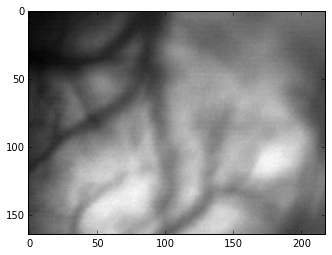

In [25]:
%matplotlib inline
tiff = TIFF.open(os.path.join(imdir, files[0]), mode='r')
sample = tiff.read_image().astype('float')
print "sample type: %s, range: %s" % (sample.dtype, str([sample.max(), sample.min()]))
print "sample shape: %s" % str(sample.shape)
tiff.close()
plt.imshow(sample, cmap='gray')

In [26]:
# FIND CYCLE STARTS:
positions = [re.findall("\[([^[\]]*)\]", f) for f in files]
plist = list(itertools.chain.from_iterable(positions))
positions = [map(float, i.split(',')) for i in plist]

In [27]:
display(positions[0]); len(positions)

[107.55963873256827, 6.58612836456427e-15]

9232

In [28]:
if 'H-Up' in cond:
    find_cycs = list(itertools.chain.from_iterable(
        np.where(np.diff([p[1] for p in positions]) < 0)))
    moveX = 0
    condType = 4
    
if 'H-Down' in cond:
    find_cycs = list(itertools.chain.from_iterable(
        np.where(np.diff([p[1] for p in positions]) > 0)))
    moveX = 0
    condType = 3
    
if 'V-Left' in cond:
    find_cycs = list(itertools.chain.from_iterable(
        np.where(np.diff([p[0] for p in positions]) < 0)))
    moveX = 1
    condType = 1
    
if 'V-Right' in cond:
    find_cycs = list(itertools.chain.from_iterable(
        np.where(np.diff([p[0] for p in positions]) > 0)))
    moveX = 1
    condType = 2
    
idxs = [i + 1 for i in find_cycs]
idxs.append(0)
idxs.append(len(positions))
idxs = sorted(idxs)
nframes_per_cycle = [idxs[i] - idxs[i - 1] for i in range(1, len(idxs))]

In [29]:
display(idxs)

[0,
 462,
 924,
 1385,
 1847,
 2308,
 2770,
 3231,
 3693,
 4154,
 4616,
 5078,
 5539,
 6001,
 6462,
 6924,
 7385,
 7847,
 8308,
 8770,
 9232]

In [30]:
display(nframes_per_cycle) # 0.05 cyc/sec, 20sec * 60Hz fps = 1200 frames per cycle (and, 1200*20 cycles=24k frames total )

[462,
 462,
 461,
 462,
 461,
 462,
 461,
 462,
 461,
 462,
 462,
 461,
 462,
 461,
 462,
 461,
 462,
 461,
 462,
 462]

In [31]:
positions[0:5]

[[107.55963873256827, 6.58612836456427e-15],
 [107.44606818564264, 6.5791741742257764e-15],
 [106.99137453449657, 6.551332218002343e-15],
 [106.52914181122361, 6.523028626751473e-15],
 [106.06815675129559, 6.494801432846693e-15]]

In [32]:
positions[1195:1200] # idx[1] = 1198, i.e., start of cycle 2

[[-18.59026915773555, -1.1383256809654302e-15],
 [-19.055375488606174, -1.166805229933624e-15],
 [-19.519001878381488, -1.1951941586455533e-15],
 [-19.982827363371385, -1.2235952784233456e-15],
 [-20.44701121974761, -1.2520183421196964e-15]]

In [33]:
from psychopy import visual, event, core, monitors, logging, tools

In [34]:
monitor_list = monitors.getAllMonitors()

In [35]:
monitor_list

[u'AQUOS', u'testMonitor', u'BenQtest', u'syncmaster2433BW']

In [144]:
whichMonitor = 'AQUOS'
# whichMonitor = 'syncmaster2433BW'


In [145]:
winsize = monitors.Monitor(whichMonitor).getSizePix()

In [146]:
winsize

[1360, 768]

In [147]:
screen_width_cm = monitors.Monitor(whichMonitor).getWidth()
screen_height_cm = (float(screen_width_cm)/monitors.Monitor(whichMonitor).getSizePix()[0])*monitors.Monitor(whichMonitor).getSizePix()[1]

screen_width_deg = tools.monitorunittools.cm2deg(screen_width_cm, monitors.Monitor(whichMonitor))
screen_height_deg = tools.monitorunittools.cm2deg(screen_height_cm, monitors.Monitor(whichMonitor))

print [screen_width_deg, screen_height_deg]


[213.11945001432255, 120.34980706691158]


In [72]:
win = visual.Window(fullscr=True, rgb=-1, size=winsize, units='deg', monitor=whichMonitor)

In [73]:
win.close()

5.3314 	WARNING 	Use of rgb arguments to stimuli are deprecated. Please use color and colorSpace args instead
5.3319 	WARNING 	User requested fullscreen with size [1920 1200], but screen is actually [2560, 1440]. Using actual size


In [74]:
cyc_per_sec = 0.05

In [111]:
screen_width_cm = monitors.Monitor(whichMonitor).getWidth()

In [112]:
screen_height_cm = (float(screen_width_cm)/monitors.Monitor(whichMonitor).getSizePix()[0])*monitors.Monitor(whichMonitor).getSizePix()[1]

In [113]:
display(screen_width_cm); display(screen_height_cm)

51.52

32.2

In [114]:
total_length = max([screen_width_cm, screen_height_cm]); display(total_length)

51.52

In [115]:
fps = 60.

In [50]:
total_time = total_length/(total_length*cyc_per_sec)

NameError: name 'cyc_per_sec' is not defined

In [81]:
frames_per_cycle = fps/cyc_per_sec

In [82]:
display(frames_per_cycle)

1200.0

In [83]:
distance = monitors.Monitor(whichMonitor).getDistance()

In [84]:
num_seq_reps = 1.

In [85]:
duration = total_time*num_seq_reps

In [86]:
display(duration)

19.999999999999996

In [51]:
barWidth = 1

In [151]:
longside = tools.monitorunittools.cm2deg(screen_height_cm, monitors.Monitor(whichMonitor))

In [152]:
display(longside)

120.34980706691158

In [153]:
width_deg = tools.monitorunittools.cm2deg(screen_width_cm, monitors.Monitor(whichMonitor))

In [154]:
display(width_deg)

213.11945001432255

In [155]:
# [screen_width, screen_height_cm] = [93.0, 52.517647058823535]
# winsize (pixels) = [1360, 768]
# [width_deg, height_deg] = [213.11945001432255, 120.34980706691158]
# Looks like aspect ratio is constant, phew.

# 213.11945001432255/120.34980706691158
# 1360/768.
# 93.0/52.517647058823535

In [156]:
travelDist = width_deg*0.5; display(travelDist)

106.55972500716128

In [157]:
total_length_deg = tools.monitorunittools.cm2deg(total_length, monitors.Monitor(whichMonitor)); display(total_length_deg)

118.0635920939559

In [158]:
stimSize = (longside,barWidth); display(stimSize)

(120.34980706691158, 1)

In [96]:
uStartPoint = travelDist; display(uStartPoint) # this is just 0.5 of the travel dimension

73.78974505872245

In [97]:
# SPECIFICY CONDITION TYPES:
print condType
if condType == 1:
    orientation = 1 # 1 = VERTICAL, 0 = horizontal
    direction = 1 # 1 = start from LEFT or BOTTOM (neg-->pos), 0 = start RIGHT or TOP (pos-->neg)
    # as of 04/2016, this means FROM neg TO pos (left-->right {cond1: V-Left} or bottom-->top {cond4: H-Up})

elif condType == 2:
    orientation = 1 # vertical
    direction = 0 # start from RIGHT

elif condType == 3:
    orientation = 0 # horizontal
    direction = 0 # start from TOP

elif condType == 4:
    orientation = 0 # horizontal
    direction = 1 # start from BOTTOM

centerPoint = [0,0] #center of screen is [0,0] (degrees).
print direction
if direction==1: # START FROM NEG, go POS (start left-->right, or start bottom-->top)
    startSign = -1
else:
    startSign = 1

1
1


In [98]:
startPoint = startSign*uStartPoint +barWidth*0.5; display(startPoint)

-73.28974505872245

In [99]:
endPoint = -1*(startPoint + startSign*(total_length_deg*0.5-uStartPoint - barWidth*0.5)); display(endPoint)

72.78974505872245

In [100]:
total_length_deg# *0.5-uStartPoint

147.5794901174449

In [101]:
startPoint + startSign*(total_length_deg*0.5-uStartPoint + barWidth*0.5) # should be ADDING barWidth (to start AND end off screen...)
# This formulation follows the leading edge of the bar, with the edge starting offscreen and ending at the opposite side, with the caaveat
# that at the end of the cycle (V-Left), we have the cycle ending w/ the bar ON screen...

# ACTUALLY, this is wrong:  startPoint adds barWidth, thereby starting the trailing edge of the bar aligned to edge of screen... 
# and, endPoint results in the leading edge of the bar aligned to the edge of opposite side of screen... -- see Line 

-73.78974505872245

In [102]:
dist = endPoint - startPoint; display(dist)

146.0794901174449

In [103]:
total_length_deg - abs(dist)

1.5

In [104]:
# 04/12/2016 - jyr

# signs got screwed up at some point...

# SHOULD BE THIS:
#startPoint = startSign*uStartPoint - barWidth*0.5; display(startPoint)
# i.e., total_length_deg*0.5 + barWidth*0.5 -- this starts with bar OFF screen (leading edge)


#endPoint = -1*(startPoint + startSign*(total_length_deg*0.5-uStartPoint + barWidth*0.5)); display(endPoint)
# i.e., -1*total_length_deg*0.5 + barWidth*0.5 -- this starts with bar OFF screen (leading edge)

# SIMPLIFIED:
# endPoint = -1*(startPoint - startSign*(barWidth*0.5)); display(endPoint) 
# THIS is if you just want the leading edge to go from screen-end to screen-end

In [105]:
105.55972500716128 + 0.5

106.05972500716128

In [106]:
display(duration)

19.999999999999996

1260

[-73.289745058722445,
 -73.168012150291247,
 -73.046279241860034,
 -72.924546333428836,
 -72.802813424997623]

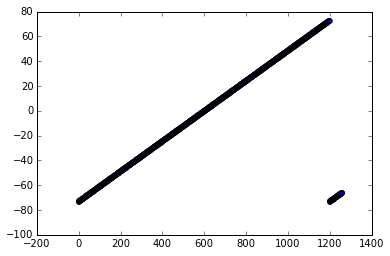

In [107]:
# STH WERID WITH POSITIONS:
# Just using linearly spaced 1/fps intervals for x frames should give similar coords, using the same end/startPoints...
# But, compare below 2 figs...

# SOLVED:
# Running with monitor settings to syncmaster:
# winsize = [1920, 1200]
# startPoint = -73.2897450587
# posX = -73.2896754026,-72.8982859728, ...
# DIST:  146.079490117
# DUR:  20.0

# i.e,. datafiles from 06.25.2015 using some other config...

import math
angle = 90 # VERT 

nframes = 21
dt = 1/fps
samples = np.arange(0,nframes,dt)
pos = []
for i in samples:
    curr_pos = (i % total_time) / total_time * (endPoint-startPoint) + startPoint
    cart_pos = curr_pos*math.sin(angle*math.pi/180)+0 #centerPoint[0]
    pos.append(cart_pos)
    
display(len(pos))
plt.scatter(np.arange(len(samples)), pos)
display(pos[0:5])

1198

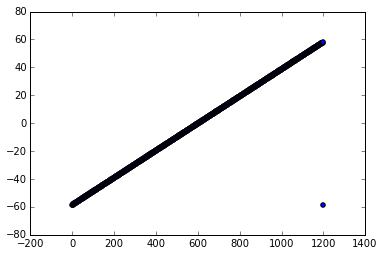

In [108]:
if moveX:
    moving_dim = [positions[i][0] for (i,p) in enumerate(positions)]
else:
    moving_dim = [positions[i][1] for (i,p) in enumerate(positions)]
    
display(idxs[1])

nframes = idxs[1] + 1
real_pos = moving_dim[0:nframes]
plt.scatter(np.arange(len(real_pos)), real_pos)

In [109]:
len(positions)

23964

In [121]:
stimSize

(92.23718132340305, 1)

In [122]:
display(startPoint); display(endPoint); display(moving_dim[0]); display(moving_dim[-1])

NameError: name 'startPoint' is not defined

In [112]:
# More weird stuff... why are timestamps so off?

from datetime import datetime
tstamps = [f.split('_')[1] for f in files]
FORMAT = '%Y%m%d%H%M%S%f'
#date = datetime.strptime(tstamps[0], FORMAT)
#display(date)
# convert string into math-able form:
#'{hrs}:{min}:{sec}.{msec}'.format(hrs = str(d.hour), min = str(d.minute), sec = str(d.second), msec = str(d.microsecond/1000))
fmt_tstamps = [datetime.strptime(t, FORMAT) for t in tstamps]
times = ['{hrs}:{min}:{sec}.{msec}'.format(hrs = str(d.hour), min = str(d.minute), sec = str(d.second), msec = str(d.microsecond)) for d in fmt_tstamps]

In [113]:
mstimes = []
for t in times:
    hours, minutes, seconds = (t.split(":"))[-3:]
    hours = int(hours)
    minutes = int(minutes)
    seconds = float(seconds)
    miliseconds = int(3600000 * hours + 60000 * minutes + 1000 * seconds)
    mstimes.append(miliseconds)

In [114]:
t

'18:28:35.618425'

In [115]:
tstamps[0:5]

['20150625182154951761',
 '20150625182154968753',
 '20150625182154985097',
 '20150625182155002058',
 '20150625182155018586']

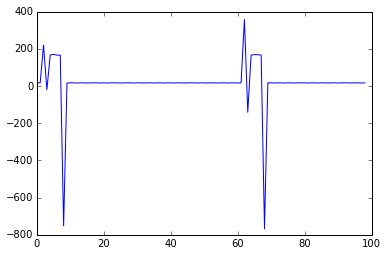

In [116]:
plt.plot(np.diff(mstimes[0:100]))

In [117]:
# x = [positions[i][0] for (i,p) in enumerate(positions)]
P = [i for i in moving_dim]
display(P[0])
display(P[idxs[1]-1])
display(P[idxs[1]])
sim = np.zeros((len(P), ))

-58.53176130832045

57.933660729079655

-58.531743244218546

In [118]:
P[0:5]

[-58.53176130832045,
 -58.42719239105267,
 -58.32994360369381,
 -58.235869929630695,
 -58.13534042345731]

In [159]:
window = [np.ceil(screen_width_deg), np.ceil(screen_height_deg)]
print window


[214.0, 121.0]


In [170]:
# import pygame
# import sys

# shift_P = [i+np.ceil(max(P)) for i in P]

# w=abs(np.ceil(abs(P[0])+barWidth)*2) # include offset to compensate for stupid positioning above...
# h=abs(np.ceil(stimSize[0]))
# display(w,h)

# black = (0,0,0)
# white = (255,255,255)

import pygame
import sys

# shift_P = [i+np.ceil(max(P)) for i in P]

# w=abs(np.ceil(abs(P[0])+barWidth)*2) # include offset to compensate for stupid positioning above...
# h=abs(np.ceil(stimSize[0]))
w = window[0]
h = window[1]
display(w,h)

black = (0,0,0)
white = (255,255,255)

pygame.init()
screen = pygame.display.set_mode((int(w),int(h)))

screen.fill(black)

214.0

121.0

<rect(0, 0, 214, 121)>

In [171]:
# savedir = './tests/simulation/%s/' % cond
# if not os.path.exists(savedir):
#     os.makedirs(savedir)

savedir = os.path.join(os.path.split(imdir)[0], 'simulation', cond)
if not os.path.exists(savedir):
    os.makedirs(savedir)
    
print savedir

/media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0013/simulation/V-Right_1


In [254]:

# CHECK THIS -- 05/06/2016
# /media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0013/V-Right_1
# which monitor??? -- AQUOS or syncmaster?  positions don't match up....


px = [p[0] for p in positions]
py = [p[1] for p in positions]

old_min = min(px)
print old_min
old_max = max(px)
print old_max
old_range = (old_max - old_min)
new_min = 0
new_range = max(px)*2 - 0.
shift_px = [((((i - old_min) * float(new_range)) / old_range) + new_min) for i in px]
new_px = np.array([i+(w/4.) for i in shift_px]) - 54

print px[0:5]
print shift_px[0:5]
old_min = min(py)
old_max = max(py)
old_range = (old_max - old_min)
new_min = 0
new_range = max(py)*2 - 0.
shift_py = [((((i - old_min) * float(new_range)) / old_range) + new_min) for i in py]
new_py = np.flipud([i+(h/4.) for i in shift_py]) - 30

# need to flip UD because actual stim-pos assumes center of (0,0), but this is upper-left corner of pygame rect 
# also, shifted by 5 pixels to center stimulus

print py[0:5]
print shift_py[0:5]


# shift_posvec = [[shift_px[i], shift_py[i]] for i in range(len(shift_px))]
shift_posvec = [[new_px[i], new_py[i]] for i in range(len(new_py))]

-106.527817702
107.559638733
[107.55963873256827, 107.44606818564264, 106.99137453449657, 106.52914181122361, 106.06815675129559]
[215.11927746513658, 215.00515955088383, 214.5482744473302, 214.08381393615716, 213.62060710159722]
[6.58612836456427e-15, 6.5791741742257764e-15, 6.551332218002343e-15, 6.523028626751473e-15, 6.494801432846693e-15]
[1.317225672912854e-14, 1.3165269022207792e-14, 1.3137292878225539e-14, 1.3108852874308621e-14, 1.3080489635944272e-14]


In [255]:
pygame.init()
screen = pygame.display.set_mode((int(w),int(h)))

screen.fill(black)

barw = stimSize[1]
barh = stimSize[0]

screen.fill(black)

i=461
posx = shift_posvec[i][0]
posy = shift_posvec[i][1]

pygame.draw.rect(screen, white, (posx,posy,barw,barh), 0)
pygame.display.update()

In [256]:
# pygame.init()
# screen = pygame.display.set_mode((int(w),int(h)))

screen.fill(black)

# savedir = './tests/simulation/%s/' % cond
# if not os.path.exists(savedir):
#     os.makedirs(savedir)

# stimSize = (longside,barWidth); display(stimSize)

barw = stimSize[1]
barh = stimSize[0]

actual_nframes = len(positions)

delay_secs = 5 # n seconds to wait to simulate hemo "delay"
delay_frames = delay_secs * fps


nframes = 0
while nframes < actual_nframes:
#     if moveX:
#         posx=shift_P[nframes]
#         posy=0 #shift_x[nframes]
#     else:
#         posx=0
#         posy=shift_P[nframes]

    posx = shift_posvec[nframes][0]
    posy = shift_posvec[nframes][1]

        
    screen.fill(black)
    pygame.draw.rect(screen, white, (posx,posy,barw,barh), 0)
    pygame.display.update()
    pygame.image.save(screen, os.path.join(savedir, "screen_%i.bmp" % nframes))
    nframes += 1

In [61]:
nframes_collected = os.listdir(savedir)
print("N frames: %s" % str(len(nframes_collected)))
print("N positions: %s" % str(len(positions)))

N frames: 23964
N positions: 23964


In [62]:
sim_frames = sorted([i for i in nframes_collected if i.split('.')[1]=='bmp'], key=natural_keys)

In [68]:
from PIL import Image
sim=Image.open(os.path.join(savedir, sim_frames[-1]),'r')

SIM IMAGE SHAPE: (120, 93)


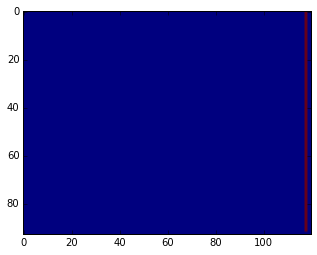

In [69]:
# is it working...?
# sim = Image.open(os.path.join("./stimuli/simulated", sim_frames[100])).convert('LA')
# sim=sim.convert('1') # make BW so don't have to deal with 3d
# lena = misc.imread(os.path.join("./stimuli/simulated", sim_frames[100]))

# sim=Image.open(os.path.join(savedir, sim_frames[100]),'r')
sim=sim.convert('L') #makes it greyscale
y=np.asarray(sim.getdata(),dtype=np.float64).reshape((sim.size[1],sim.size[0]))
y=np.asarray(y,dtype=np.uint8)

plt.imshow(y)
print "SIM IMAGE SHAPE: %s" % str(sim.size)

In [26]:
y.max()

255

In [27]:
stack = np.empty((sim.size[1], sim.size[0], len(sim_frames)))
print stack.shape

for i, f in enumerate(sim_frames):
    if i % 1000 == 0:
        print('%d images processed...' % i)
    sim=Image.open(os.path.join(savedir, sim_frames[i]),'r')
    sim=sim.convert('L') #makes it greyscale
    y=np.asarray(sim.getdata(),dtype=np.float64).reshape((sim.size[1],sim.size[0]))
    stack[:, :, i] = y

(93, 120, 23964)
0 images processed...
1000 images processed...
2000 images processed...
3000 images processed...
4000 images processed...
5000 images processed...
6000 images processed...
7000 images processed...
8000 images processed...
9000 images processed...
10000 images processed...
11000 images processed...
12000 images processed...
13000 images processed...
14000 images processed...
15000 images processed...
16000 images processed...
17000 images processed...
18000 images processed...
19000 images processed...
20000 images processed...
21000 images processed...
22000 images processed...
23000 images processed...


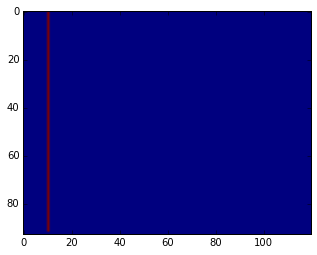

In [31]:
plt.imshow(stack[:,:,100])

In [32]:
for i in range(stack.shape[2]):
    stack[:,:,i] -= np.mean(stack[:,:,i].ravel())

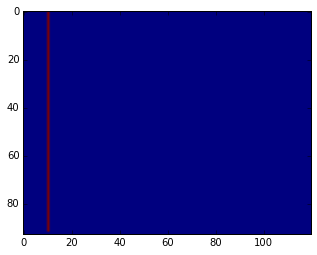

In [33]:
plt.imshow(stack[:,:,100])

In [130]:
freqs = fft.fftfreq(len(stack[0, 0, :]), 1 / sampling_rate) # When set fps to 60 vs 120 -- target_bin should be 2x higher for 120, but freq correct (looks for closest matching target_bin )
binwidth = freqs[1] - freqs[0]
#target_bin = int(target_freq / binwidth)
target_bin = np.where(freqs == min(freqs, key=lambda x: abs(float(x) - target_freq)))[0][0]
print "TARGET: ", target_bin, freqs[target_bin]
print "FREQS: ", freqs

TARGET:  20 0.050075112669
FREQS:  [ 0.          0.00250376  0.00500751 ..., -0.00751127 -0.00500751
 -0.00250376]


In [131]:

# FFT:
sample = stack[:,:,0]
mag_map = np.empty(sample.shape)
phase_map = np.empty(sample.shape)

ft_real = np.empty(sample.shape)
ft_imag = np.empty(sample.shape)

ft_real_shift = np.empty(sample.shape)
ft_imag_shift = np.empty(sample.shape)

dynrange = np.empty(sample.shape)

ft = np.empty(sample.shape)
ft = ft + 0j

#dlist = []
i = 0
for x in range(sample.shape[0]):
    for y in range(sample.shape[1]):

        # THIS IS BASICALLY MOVING AVG WINDOW...
        pix = scipy.signal.detrend(stack[x, y, :], type='constant')

        #dynrange[x, y] = np.log2(pix.max() - pix.min())

        curr_ft = fft.fft(pix)  # fft.fft(pix) / len(pix)])
        #curr_ft_shift = fft.fftshift(curr_ft)

# DF = pd.DataFrame.from_records(dlist)

        #mag = np.abs(curr_ft)
        # mag_max = np.where(mag == mag.max())
        # mag_min = np.where(mag == mag.min())
        
        phase = np.angle(curr_ft)

        ft_real[x, y] = curr_ft[target_bin].real
        ft_imag[x, y] = curr_ft[target_bin].imag
        
        ft[x,y] = curr_ft[target_bin]

        #ft_real_shift[x, y] = curr_ft_shift[target_bin_shift].real
        #ft_imag_shift[x, y] = curr_ft_shift[target_bin_shift].imag

        # if i % 100 == 0:
        # print ft_real[x, y], ft_imag[x,y]

        #mag_map[x, y] = mag[target_bin]
        phase_map[x, y] = phase[target_bin]

        #dlist.append((x, y, curr_ft))

        i += 1

In [132]:
os.path.split(os.path.split(savedir)[0])[0]

'./tests/simulation'

In [34]:
outdir = os.path.join(os.path.split(os.path.split(savedir)[0])[0], "structs")
append_to_name = "simulated"
outdir


'./tests/simulation/structs'

In [134]:

D = dict()

D['ft_real'] = ft_real  # np.array(ft)
D['ft_imag'] = ft_imag
D['ft'] = ft

# D['mag_map'] = mag_map
D['phase_map'] = phase_map

D['mean_intensity'] = np.mean(stack, axis=2)
#D['stack'] = stack
#del stack
D['dynrange'] = dynrange
D['target_freq'] = target_freq
D['fps'] = sampling_rate
D['freqs'] = freqs  # fft.fftfreq(len(pix), 1 / sampling_rate)
# D['freqs_shift'] = freqs_shift #fft.fftfreq(len(pix), 1 / sampling_rate)

D['binsize'] = freqs[1] - freqs[0]
# np.where(freqs == min(freqs, key=lambda x: abs(float(x) - target_freq)))[0][0]
D['target_bin'] = target_bin
#D['target_bin_shift'] = target_bin_shift
D['nframes'] = nframes_per_cycle
D['reduce_factor'] = reduce_factor

# SAVE condition info:
sessionpath = os.path.split(imdir)[0]
# outdir = os.path.join(sessionpath, 'structs')
# if not os.path.exists(outdir):
#     os.makedirs(outdir)

reduce_factor = (1, 1)
fext = 'D_target_FFT_%s_%s_%s.pkl' % (cond, str(reduce_factor), append_to_name)
fname = os.path.join(outdir, fext)
with open(fname, 'wb') as f:
    # protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(D, f, protocol=pkl.HIGHEST_PROTOCOL)

In [49]:
# outdir = "./tests/simulation/V-Left_0/structs"
os.listdir(outdir)
outdir

'./tests/simulation/structs'

In [38]:
#####################################################
# TEST MERGE:
#####################################################

reduce_factor = (1,1)
print outdir
flist = os.listdir(outdir)

flist = [f for f in flist if os.path.splitext(f)[1] == '.pkl']
print flist
dstructs = [f for f in flist if 'D_target_FFT' in f and str(reduce_factor) in f]
# if not dstructs:
#     dstructs = [f for f in flist if 'D_' in f and str(reduce_factor) in f]

print dstructs
    
D = dict()
for f in dstructs:
    outfile = os.path.join(outdir, f)
    with open(outfile,'rb') as fp:
        D[f] = pkl.load(fp)

./tests/simulation/structs
['D_target_V-Right_0_(1, 1)_simulated_orig.pkl', 'D_target_FFT_H-Down_0_(1, 1)_simulated.pkl', 'D_target_V-Left_0_(1, 1)_simulated.pkl', 'D_target_FFT_V-Left_0_(1, 1)_simulated.pkl', 'D_target_FFT_V-Right_0_(1, 1)_simulated.pkl', 'D_target_FFT_H-Up_0_(1, 1)_simulated.pkl', 'D_target_V-Right_0_(1, 1)_simulated.pkl', 'D_target_V-Left_0_(1, 1)_True.pkl']
['D_target_FFT_H-Down_0_(1, 1)_simulated.pkl', 'D_target_FFT_V-Left_0_(1, 1)_simulated.pkl', 'D_target_FFT_V-Right_0_(1, 1)_simulated.pkl', 'D_target_FFT_H-Up_0_(1, 1)_simulated.pkl']


In [39]:
for d in D.keys():
    if "Left" in d:
        leftkey = d
    elif "Right" in d:
        rightkey = d
print D.keys()

['D_target_FFT_V-Right_0_(1, 1)_simulated.pkl', 'D_target_FFT_H-Down_0_(1, 1)_simulated.pkl', 'D_target_FFT_V-Left_0_(1, 1)_simulated.pkl', 'D_target_FFT_H-Up_0_(1, 1)_simulated.pkl']


In [40]:
# print min([ftmap[rightkey].shape, ftmap[leftkey].shape])
# leftmap = np.zeros(min([ftmap[rightkey].shape, ftmap[leftkey].shape]))
# rightmap = np.zeros(min([ftmap[rightkey].shape, ftmap[leftkey].shape]))

# leftmap = leftmap + 0j
# rightmap = rightmap + 0j


leftmap = D[leftkey]['ft']
rightmap = D[rightkey]['ft'][:,0:120]

In [41]:
rightmap.shape

(93, 120)

<matplotlib.colorbar.Colorbar instance at 0x7fe81aa3ab48>

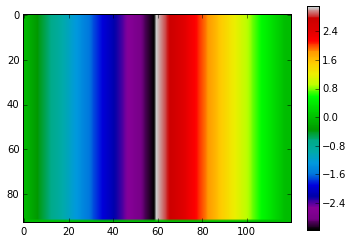

In [45]:
phase_left = np.angle(leftmap)
plt.imshow(phase_left, cmap='spectral')
plt.colorbar()

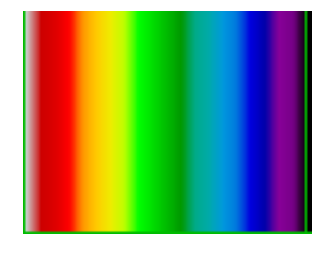

In [55]:
# SHIFT NEGATIVE VALUES by 2PI

import math
phase_left = np.angle(leftmap)
phase_right = np.angle(rightmap)

for x in range(phase_left.shape[0]):
    for y in range(phase_left.shape[1]):
        if phase_left[x,y] < 0:
            phase_left[x,y] += 2*math.pi

for x in range(phase_right.shape[0]):
    for y in range(phase_right.shape[1]):
        if phase_right[x,y] < 0:
            phase_right[x,y] += 2*math.pi

        
# plt.imshow(phase_left, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
phase_left

# plt.subplot(1,2,2)
# plt.imshow(phase_right, cmap='spectral')
# plt.colorbar()
        
az = (phase_left - phase_right) / 2.
# plt.imshow(az, cmap='spectral') #, vmin=-1*math.pi, vmax=1*math.pi)
plt.imshow(az, cmap='spectral') #, vmin=0, vmax=2*math.pi)
# plt.colorbar()
# plt.colorbar()
# x = np.where(phase_left<0)
# len(x[1])
# phase_left.max()
az.min()

plt.axis('off')

# plt.colorbar()

legend_path = '/home/juliana/Repositories/retinotopy-mapper/tests/simulation/LEFT_RIGHT_legend.tif'
plt.savefig(legend_path)
# print az[-5]

[-0.01195602  3.0944027   3.04197291  2.98841946  2.93469808  2.88180209
  2.82806864  2.77426141  2.72070648  2.66733827  2.61372288  2.5600421
  2.50731928  2.45410418  2.40057897  2.3471697   2.294454    2.24048406
  2.18564951  2.13244588  2.07985851  2.0262631   1.97270509  1.92004939
  1.86670288  1.81263785  1.75940072  1.70602805  1.65173487  1.59798351
  1.54523141  1.49182359  1.43813036  1.38520015  1.33248408  1.27882825
  1.22426392  1.17071791  1.11748489  1.06390282  1.0106508   0.95801693
  0.90452628  0.85040859  0.79749212  0.74468339  0.68991967  0.63580173
  0.58314353  0.52992716  0.47618642  0.42323225  0.37080246  0.31697272
  0.26290952  0.20954962  0.15540267  0.10136844  0.04835885 -0.00407094
 -0.05751778 -0.11135659 -0.16430105 -0.21727293 -0.27137617 -0.32551267
 -0.37894434 -0.4324741  -0.48597567 -0.53885563 -0.59136951 -0.64540118
 -0.69930218 -0.75210892 -0.8063921  -0.86060768 -0.91367423 -0.96615881
 -1.01966649 -1.07334728 -1.1260701  -1.17954192 -1.

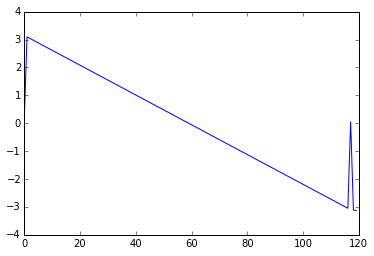

In [59]:
plt.plot(az[-5])
print az[-5]

<matplotlib.colorbar.Colorbar instance at 0x7f01d2174b48>

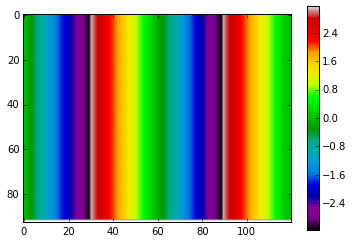

In [168]:
#########################################################################
# STIM MAPS:
#########################################################################

azimuth_phase = np.angle( (leftmap / rightmap) )
# azimuth_phase = ( np.angle(leftmap) - np.angle(rightmap) ) / 2. 
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.colorbar()
# THIS IS DOUBLE-COLOR-MAPPED, i.e., [from LEFT --> RIGHT] 0 --> -pi, pi --> 0 --> -pi, pi --> 0.

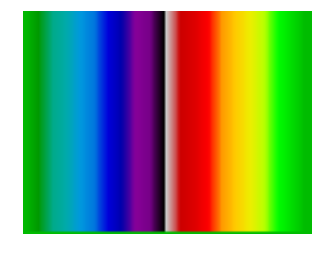

In [172]:
#####################################################
# V-LEFT_0 STIMULATION:
# ---------------------------------------------------
plt.imshow(np.angle(leftmap), cmap='spectral')
plt.axis('off')

legend_path = '/home/juliana/Repositories/retinotopy-mapper/tests/simulation/V-Left_legend.tif'
plt.savefig(legend_path)
#####################################################
# THIS IS GOING:
# 0 (LEFT edge) to -pi, to pi, back to 0

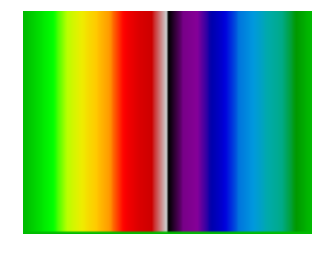

In [171]:
#####################################################
# V-RIGHT_0 STIMULATION:
# ---------------------------------------------------
plt.imshow(np.angle(rightmap), cmap='spectral')
plt.axis('off')

legend_path = '/home/juliana/Repositories/retinotopy-mapper/tests/simulation/V-Right_legend.tif'
plt.savefig(legend_path)
#####################################################
# THIS IS GOING:
# 0 (right edge) to -pi, to pi, back to 0

<matplotlib.colorbar.Colorbar instance at 0x7f01d29a8320>

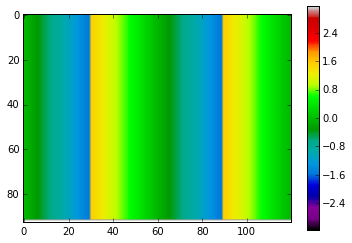

In [156]:
azimuth_phase = np.angle(leftmap / rightmap) / 2
# azimuth_phase = ( np.angle(leftmap) - np.angle(rightmap) ) / 2. 
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f01d286e488>

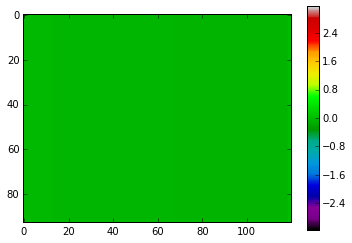

In [157]:
#########################################################################
# DELAY MAP:
#########################################################################
delay_vert = np.angle(leftmap * rightmap) / 2
# azimuth_phase = ( np.angle(leftmap) - np.angle(rightmap) ) / 2. 
plt.imshow(delay_vert, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.colorbar()

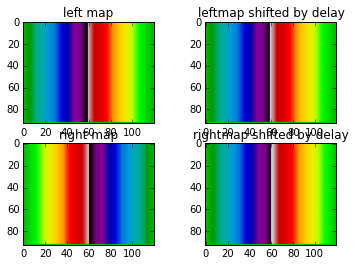

In [158]:
# azimuth_phase = np.angle(leftmap / rightmap) / 2. 
# azimuth_phase = ( np.angle(leftmap) - np.angle(rightmap) ) / 2

fig = plt.figure()
fig.add_subplot(2,2,1)
left_phase = np.angle(leftmap)
plt.imshow(left_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.title('left map')

fig.add_subplot(2,2,2)
# azimuth_phase = np.angle(leftmap.conjugate()) - delay_vert
azimuth_phase = np.angle(leftmap) - delay_vert
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
# plt.colorbar()
plt.title('leftmap shifted by delay')

fig.add_subplot(2,2,3)
right_phase = np.angle(rightmap)
plt.imshow(right_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.title('right map')

fig.add_subplot(2,2,4)
azimuth_phase = np.angle(rightmap.conjugate()) - delay_vert
# azimuth_phase = np.angle(rightmap) - delay_vert
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
# plt.colorbar()
plt.title('rightmap shifted by delay')

<matplotlib.colorbar.Colorbar instance at 0x7fe81a88f200>

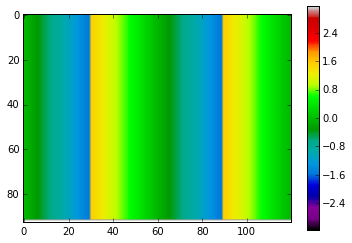

In [46]:
azimuth_phase = np.angle(leftmap / rightmap) / 2. 
# azimuth_phase = ( np.angle(rightmap) - np.angle(leftmap) ) / 2. 
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f01d2448368>

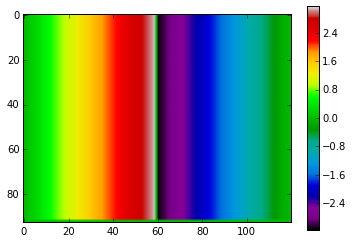

In [160]:
# azimuth_phase = np.angle(leftmap / rightmap) / 2. 
azimuth_phase = ( np.angle(rightmap) - np.angle(leftmap) ) / 2. 
# fig=plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
# cbar = plt.colorbar(fig) 
# cbar.ax.invert_yaxis()
plt.imshow(azimuth_phase, cmap='spectral', vmin=1*math.pi, vmax=-1*math.pi)
plt.colorbar()

In [161]:
###########################################################################################################

In [162]:
# DONT DO THIS.

# ftmap = dict()
# # outshape = D[D.keys()[0]]['ft_real'].shape
# # print outshape
# for curr_key in D.keys():
#     outshape = D[curr_key]['ft_real'].shape # WTF, outshape changing based on stim... (but maybe not for actual imaging acquis. data)
#     print outshape
#     reals = D[curr_key]['ft_real'].ravel()
#     imags = D[curr_key]['ft_imag'].ravel()
# #     imags = imags*-1.
# #     if 'Down' in curr_key:
# #         imags = imags*-1
# #     if 'Right' in curr_key:
# #         imags = imags*-1
#     ftmap[curr_key] = [complex(x[0], x[1]) for x in zip(reals, imags)]
#     ftmap[curr_key] = np.reshape(np.array(ftmap[curr_key]), outshape)


In [822]:
# WTF, why multipling by -1.... imags are just imags!

i = 2
j = -3
c = complex(2,3)
# c = 2-3j
# print c
print c.real
print c.imag

c = 2-3j
print type(c)
cr = c.real
ci = c.imag
print cr, ci

2.0
3.0
<type 'complex'>
2.0 -3.0


In [ ]:
###########################################################################################################

In [1191]:
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')

rgba = cmap(0.5)
print(rgba)

from matplotlib import cm


(0.99807766255210428, 0.99923106502084169, 0.74602077638401709, 1.0)


(0.80000000000000004, 0.80000000000000004, 0.80000000000000004, 1.0)

In [1234]:
# map_shape = leftmap.shape
# screen_legend = np.zeros(map_shape)

screen_size = [int(i*0.25) for i in winsize]
print screen_size
screen_legend = np.zeros((screen_size[1], screen_size[0]))

VERT = 1
left = 1

if VERT: 
    if left:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, -1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end
    if right:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end

if HORZ:
    if up:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, -1*math.pi, screen_size[0]/2)
        for i in range(screen_size[0]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end
    if right:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end

plt.imshow(screen_legend, cmap='spectral')

[480, 300]


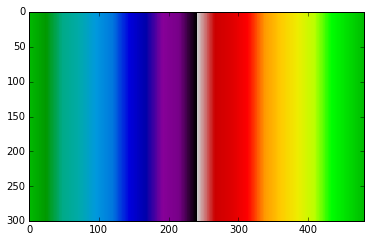

In [1235]:
###################################################
# V-LEFT:
###################################################

plt.imshow(screen_legend, cmap='spectral')

In [1233]:
screen_legend[i][240]

0.0

In [1221]:
screen_legend[i].shape

(480,)

In [1240]:
screen_size = [int(i*0.25) for i in winsize]
print screen_size
screen_legend = np.zeros((screen_size[1], screen_size[0]))

VERT = 1
left = 0

HORZ = 0
up = 1

if VERT: 
    if left:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, -1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end
    else:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end

if HORZ:
    if up:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, -1*math.pi, screen_size[0]/2)
        for i in range(screen_size[0]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end
    else:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end


[480, 300]


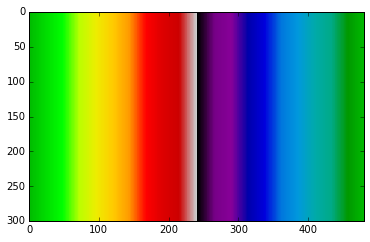

In [1241]:
###################################################
# V-RIGHT:
###################################################

plt.imshow(screen_legend, cmap='spectral')
